In [1]:
pip install transformers accelerate datasets evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np

In [3]:
# load dataset
dataset = load_dataset("hebashakeel/wellness_project_dataset")
dataset

README.md:   0%|          | 0.00/514 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/91.1k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/22.1k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/990 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/212 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/213 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 990
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 212
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 213
    })
})

In [7]:
model_name = 'gpt2'

# define label maps
id2label = {0: "Intellectual Aspect", 1: "Vocational Aspect", 2: "Spiritual Aspect", 3: "Physical Aspect", 4: "Social Aspect", 5: "Emotional Aspect"}
label2id = {"Intellectual Aspect": 0, "Vocational Aspect": 1, "Spiritual Aspect" : 2, "Physical Aspect": 3, "Social Aspect": 4, "Emotional Aspect":5 }

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=6, id2label=id2label, label2id=label2id)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=6, bias=False)
)

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
model.config.pad_token_id = model.config.eos_token_id
# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [10]:
def tokenize_function(examples):
    text = examples["text"]
    tokenizer.trucation_slide = "left"
    tokenizer.pad_token = tokenizer.eos_token
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        padding=True,
        max_length=512
    )
    return tokenized_inputs

In [11]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/990 [00:00<?, ? examples/s]

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Map:   0%|          | 0/213 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 990
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 212
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 213
    })
})

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
accuracy = evaluate.load("accuracy")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)

In [14]:
import torch

In [15]:
text_list = dataset['train']['text'][0:5]
label = dataset['test']['labels'][0:5]
print(label)
print("Without Fine-tuning")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " ,predictions.tolist())

[3, 4, 2, 5, 4]
Without Fine-tuning
“I’m beginning to think that it’s nothing to do with my body. But my mind.” -  0
I’ve been stuck in the same job for years, and I feel like I’m not growing or learning anything new -  2
"If I told them I'm struggling with an eating disorder, what are they going to do to help me?" -  2
“I made friends with a girl later in CIT, A and it was good at first, but I wasn't feeling it anymore after a while, but I was scared to end it because I knew she would bully me. I ended it eventually and she's now bullying me even worse than I thought she would.” -  0
"My inner turmoil often resembles a high-speed train derailing at neck-breaking speeds, causing chaos and fear." -  0


In [16]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['c_attn','c_proj'])


In [17]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 410,112 || all params: 124,855,296 || trainable%: 0.3285


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [18]:
lr = 3e-4
batch_size = 4
num_epochs = 10

training_args = TrainingArguments(
    output_dir=model_name + '-lora-text-classification',
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='epoch',  
    logging_dir='./logs',     
    load_best_model_at_end=True
)

In [19]:
import wandb
wandb.init(mode='disabled')

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [21]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.120700,1.613434,0.433962
2,1.383300,1.062599,0.594340
3,1.028800,0.981035,0.622642
4,0.845000,1.088880,0.669811
5,0.742200,1.074280,0.655660
6,0.644800,1.089577,0.655660
7,0.533600,1.204819,0.674528
8,0.477700,1.299408,0.632075
9,0.403000,1.401441,0.627358
10,0.373200,1.408077,0.632075


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embeddi

TrainOutput(global_step=1240, training_loss=0.8552391821338284, metrics={'train_runtime': 301.6261, 'train_samples_per_second': 32.822, 'train_steps_per_second': 4.111, 'total_flos': 675235782144000.0, 'train_loss': 0.8552391821338284, 'epoch': 10.0})

In [22]:
text_list = dataset['test']['text']
label = dataset['test']['labels']
#print(label)
print("With Fine-tuning")
pred = []
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to('cuda')
    logits = model(inputs).logits
    predictions = torch.argmax(logits)
    pred.append(predictions.tolist())

With Fine-tuning


In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(label,pred))

              precision    recall  f1-score   support

           0       0.60      0.47      0.53        19
           1       0.69      0.78      0.73        23
           2       0.41      0.48      0.44        27
           3       0.87      0.70      0.78        47
           4       0.67      0.94      0.78        64
           5       0.67      0.24      0.36        33

    accuracy                           0.66       213
   macro avg       0.65      0.60      0.60       213
weighted avg       0.67      0.66      0.64       213



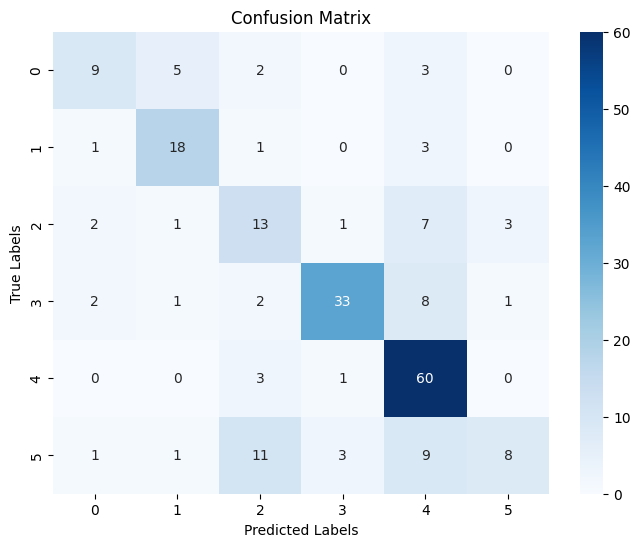

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(label, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(6), yticklabels=range(6))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()